In [57]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import time
# from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Tanzania Machine Learning Water Pump Classification
## Modeling Notebook

**Author:** Dylan Dey

This project it available on github here: (insert link here)

The Author can be reached at the following email: ddey2985@gmail.com

## Classification Metric Understanding

Below is a confusion matrix that would be produced from a model performing predictive maintenance on behalf of the Ministry of Water. There are four possible outcomes to be considered. The confusion matrix below is a visual aid to help in understanding what classification metrics to consider when building the model.  

![Confusion Matrix Description](images/confusion_matrix_overview.jpg)

A true positive in the current context would be when the model correctly identifies a functional pump as functional. A true negative would be when the model correctly identifies a non-functional pump as non-functional. Both are important and both can be described by the overall **accuracy** of the model.

True negatives are really at the heart of the model, as this is the situation in which the Ministry of Water would have a call to action. An appropriately outfitted team would be set to *all* pumps that my model identifies as non-functional. Thus, this is the situation in which the correct resources are being derived to the correct water pumps as quickly as possible. High accuracy would mean that more resources are going to the correct locations from the get-go. 

True positives are also important. This is where the model will really be saving time, resources, and money for the Ministry of Water. *Any* pumps identified as functional would no longer need to be physically checked and the Ministry of Water can withhold additional resources from going to pumps that do not actually need them. 

Notice the emphasis on *any* and *all* pumps in my description of true negatives and true positives above. The true cost/resource analysis is really the consideration of this fact: no model I create will ever correctly identify every single pump appropriately. This is the cost of predictive maintenance and a proper understanding of false positives and false negatives is extremely important in production of classification models in the given context.

False positives in the current context are the worst case scenario for modeling. This is the scenario in which the model **incorrectly** identifies a non-functional model as functional. Thus, resources would be withheld and no team would be sent to physically check these pumps, as the Ministry of Water would have to assume they are indeed functional if they want to use the model appropriately. False positives therefore describe the number of non-functional pumps that will go unvisited and unfixed until they can be resolved by other means. Reducing false positives as much as possible is very important.

Well, why would I want to build the model if these false positives cannot be completely avoided? Cost/resource management, of course! Afterall, it is about making sure as many people get clean water as quickly as possible. The reality is there that resources are finite, and without the model the Ministry of Water likely would not have the resources to physically check all the pumps and then fix all of the pumps in any sort of reasonable timeline, and even less communities would have access to fresh water when compared to using the model for predictive maintenance. 

False negatives are also important to consider. While false positives can be considered more harmful overall, false negatives are also important to reduce as much as possible. In the given context, false negatives describe the situation in which the model **incorrectly** identifies a functional pump as non-functional. Because the Ministry of water will deploy fully equipped teams to visit all pumps that my model predicts to be non-functional, these will be the pumps that will waste resources. Resources will be sent to locations that they aren't needed, and the metric that describes this would be false negatives. Thus, reduction of false negatives is essential in improving the efficiency of resource management through predictive maintenance. 

In summary, overall accuracy of the model and a reduction of both false negatives and false positives are the most important metrics to consider when developing a model in this context. More specifically, models will be tuned to **maximize accuracy and f1-score.**

Accuracy:

f1-score:

#### Function Definition

Below are all of the functions used for preprocessing data before modeling.

In [2]:
def drop_cols(water_pump_df):
    to_drop_final = ['id', 'recorded_by', 'num_private',
          'waterpoint_type_group', 'source',
          'source_class', 'extraction_type',
          'extraction_type_group', 'payment_type',
          'management_group', 'scheme_name',
          'water_quality', 'quantity_group',
          'scheme_management', 'longitude',
          'latitude', 'date_recorded',
          'amount_tsh', 'gps_height',
          'region_code', 'district_code']
          #'population'
    
    return water_pump_df.drop(columns=to_drop_final, axis=1)

#helper function to bin construction year
def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
def bin_construction_year(water_pump_df):
    water_pump_df['construction_year'] = water_pump_df.apply(lambda row: construction_wrangler(row), axis=1)
    return water_pump_df
    

#takes zero placeholders and NAN values and converts them into 'unknown'
def fill_unknowns(water_pump_df):    
    installer_index_0 = water_pump_df['installer'] =='0'
    funder_index_0 = water_pump_df['funder'] =='0'
    water_pump_df.loc[installer_index_0, 'installer'] = 'unknown'
    water_pump_df.loc[funder_index_0, 'funder'] = 'unknown'
    water_pump_df.fillna({'installer':'unknown', 
                   'funder':'unknown', 
                   'subvillage': 'unknown'}, inplace=True)
    return water_pump_df
    
#returns back boolean features without NANs while maintaining same ratio of True to False as with NANs    
def fill_col_normal_data(water_pump_df):
    filt = water_pump_df['permit'].isna()
    probs = water_pump_df['permit'].value_counts(normalize=True)
    water_pump_df.loc[filt, 'permit'] = np.random.choice([True, False], 
                       size=int(filt.sum()),
                       p = [probs[True], probs[False]])
    filt = water_pump_df['public_meeting'].isna()
    probs = water_pump_df['public_meeting'].value_counts(normalize=True)
    water_pump_df.loc[filt, 'public_meeting'] = np.random.choice([True, False], 
                       size=int(filt.sum()),
                       p = [probs[True], probs[False]])
    return water_pump_df



def apply_cardinality_reduct(water_pump_df, reduct_dict):
    for col, categories_list in reduct_dict.items():
        water_pump_df[col] = water_pump_df[col].apply(lambda x: x if x in categories_list else 'Other')
    return water_pump_df
        


#one_hot_incode categorical data
def one_hot(water_pump_df):
    final_cat = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'permit', 'construction_year',
       'extraction_type_class', 'management', 'payment', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type']
    
    water_pump_df = pd.get_dummies(water_pump_df[final_cat], drop_first=True)
    
    return water_pump_df

    
    
#master function for cleaning dataFrame
def clean_dataFrame(water_pump_df, reduct_dict):
    water_pump_df = drop_cols(water_pump_df)
    water_pump_df = bin_construction_year(water_pump_df)
    water_pump_df = fill_unknowns(water_pump_df)
    water_pump_df = fill_col_normal_data(water_pump_df)
    water_pump_df = apply_cardinality_reduct(water_pump_df, reduct_dict)
    water_pump_df = one_hot(water_pump_df)
    
    return water_pump_df

###############################################
# The rest of the functions in this section
#define functions that reduce cardinality
#by mapping infrequent values ot other
#the dictionary derived from these functions
#will be used by my_funk in my master 
#clean_dataFrame function

#helper function for reducing cardinality    
def cardinality_threshold(column,threshold=0.65):
    #calculate the threshold value using
    #the frequency of instances in column
    threshold_value=int(threshold*len(column))
    #initialize a new list for lower cardinality column
    categories_list=[]
    #initialize a variable to calculate sum of frequencies
    s=0
    #Create a dictionary (unique_category: frequency)
    counts=Counter(column)

    #Iterate through category names and corresponding frequencies after sorting the categories
    #by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the total sum
        s += dict(counts)[i]
        #append the category name to the categories list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s >= threshold_value:
            break
        #append the new 'Other' category to list
        categories_list.append('Other')

    #Take all instances not in categories below threshold  
    #that were kept and lump them into the
    #new 'Other' category.
    new_column = column.apply(lambda x: x if x in categories_list else 'Other')
#     return new_column
    return categories_list
     
 #reduces the cardinality of appropriate categories   
def get_col_val_mapping(water_pump_df):
    col_threshold_list = [
        ('funder',0.65), 
        ('installer', 0.65),
        ('wpt_name', 0.15),
        ('subvillage', 0.07),
        ('lga', 0.6),
        ('ward', 0.05)
    ]
    
    reduct_dict = {}
    
    for col, thresh in col_threshold_list:
        reduct_dict[col] = cardinality_threshold(water_pump_df[col],
                                                   threshold= thresh)
        
    return reduct_dict

# reduct_dict is a key value mapper that will
# be used for both training and testing sets
# in order to reduce cardinality of the data

#### Import The Data From Multiple Sources

I used a number of sources for my data to use for modeling in this notebook. The cell below imports the original data from the DrivenData competition, data derived from DrivenData in QGIS and opensource hydrology data, and population data from Tanzania government census in 2012.

In [3]:
#import data from DrivenData
train_labels = pd.read_csv('files/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
train_features = pd.read_csv('files/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
df = train_features.merge(train_labels, on='id').copy()
#import QGIS derived data and prepare for model
river_df = pd.read_csv('data/river_dist2.csv')
#removing outliers
index_riv = river_df[river_df['HubDist'] >66].index
river_median = river_df['HubDist'].median()
river_df.loc[index_riv, 'HubDist'] = river_median

#create boolean for pump being within 8 km of river
river_s = river_df['HubDist'].copy()
river_s.rename('near_river', inplace=True) 
near_river = river_s[river_s < 8].apply(lambda x: 1 if not pd.isnull(x) else np.nan)
df = df.join(near_river)
df.near_river.fillna(0, inplace=True)

#import population data from 2012 government census
df_pop = pd.read_excel('data/tza-pop-popn-nbs-baselinedata-xlsx-1.xlsx')

#create a dictionary of values with format {Ward : Total Population}

pop_index = df_pop.groupby('Ward_Name')['total_both'].sum().index
pop_values = df_pop.groupby('Ward_Name')['total_both'].sum().values
pop_dict = dict(zip(pop_index, pop_values))

#create pandas Dataframe for merging
pop_dataframe = pd.DataFrame.from_dict(pop_dict, orient='index')
#rename column for clarity
pop_dataframe.rename(columns={0: 'ward_pop'}, inplace=True)

#merge dataframes
df_pop_merge = df.merge(pop_dataframe,
                              how='left',
                              left_on='ward',
                              right_index=True)

#replace null values of ward population with
#median ward population

ward_pop_median = df_pop_merge['ward_pop'].median()
df_pop_merge.fillna(value=ward_pop_median, inplace=True)
# merge back into df and drop pop column
ward_pop_s = df_pop_merge['ward_pop'].copy()
df = df.join(ward_pop_s)
df.drop(columns=['population'], axis=1, inplace=True)


need_repair_index = df['status_group'] == 'functional needs repair'
df_binary = df.copy()
df_binary.loc[need_repair_index, 'status_group'] = 'non functional'

#### Transform Target to Numerical Data with Label Encoding 

As shown at the beginning of the project, the functional state of the water supply point is described as:
functional — It is working;
non functional — it is not working;
functional needs repair — Running, but needing maintenance.

These groups will be relabeled as:
functional: 0
functional needs repair: 1
non functional: 2

This would be for future work in which I didn't bin funcitonal needs repair with non functional. I chose this simplified way to deal with the imbalanced dataset not only due to time-constraints but because it is extremely difficult to get meanigful predictive power for the .functional needs repair' label due to the nature of the dataset. 

For the modeling in this notebook the target data will be relabeled as the following after binning function needs repar with non-functional:

functional: 0  

non_functional: 1

In [4]:
df_binary['status_group'].value_counts(normalize=True)

functional        0.543081
non functional    0.456919
Name: status_group, dtype: float64

In [5]:
# le = LabelEncoder()

# le.fit(['functional', 'functional needs repair', 'non functional'])

# df['status_group'] = le.transform(df.status_group)

# df['status_group'].value_counts(normalize=True)

In [6]:
le = LabelEncoder()

le.fit(['non functional','functional'])

df_binary['status_group'] = le.transform(df_binary.status_group)

df_binary['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

#### Split Data into Test and Training Sets

In [7]:
from sklearn.model_selection import train_test_split

y = df_binary['status_group']
X = df_binary.drop(columns=['status_group'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

##### Run Master Cleaning Function

In [8]:
value_maps = get_col_val_mapping(df_binary)
X_train = clean_dataFrame(X_train, value_maps)
X_test = clean_dataFrame(X_test, value_maps)
display(X_train.shape)
X_test.shape

(41580, 239)

(17820, 239)

## Data Modeling

### Baseline model

I decided to use logistic regression as my baseline model. I chose to use an arbitrary large value for C and set the solver to 'liblinear.' I did not choose to fit an intercept for the baseline model. 

In [9]:
# Instantiate the model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
logreg.fit(X_train, y_train)
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.7951634068612136
Testing Precision:  0.7886786918903065



Training Recall:  0.6681543712260436
Testing Recall:  0.6642786561264822



Training Accuracy:  0.7691678691678692
Testing Accuracy:  0.7666105499438832



Training F1-Score:  0.7261469984021912
Testing F1-Score:  0.7211532014750252


In [10]:
#Get the confusion matrix
lr_base_matrix = confusion_matrix(y_test, y_hat_test)
print(lr_base_matrix)

[[8283 1441]
 [2718 5378]]


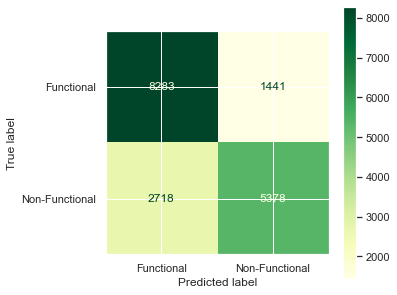

In [71]:
fig_labels = ['Functional', 'Non-Functional']
fig, ax = plt.subplots(figsize=(5, 5))

plot_confusion_matrix(logreg,
                      X_test, 
                      y_test, 
                      ax=ax, 
                      cmap='YlGn',
                     display_labels=fig_labels)

plt.show();

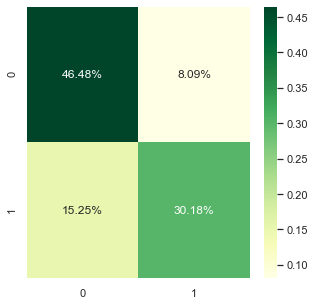

In [70]:
# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(lr_base_matrix/np.sum(lr_base_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

Below a random grid search was used to create 300 of 600 possible combinations to narrow down the paramters to do a full brute force gridCV search. The score used for determining the 'best" model was precision.

This is clearly not the way to build the model. Although I am greatly concerned with increasing my precision in order to reduce false positives, false negatives still have a fairly high cost as well.

The precision of the model is excellent. However, the accuracy and F1 scores are unnacceptable. 

I will describe why this is a poor model in more detail below under the display of the confusion matrix.

In [20]:
start = time.time()

classifier_penalties = ['l1', 'l2']
classifier_Cs = np.logspace(-5, 5, 100)
classifier__solver = ['liblinear']
    
random_grid = {'penalty' : classifier_penalties,
'C' : classifier_Cs,
'solver' : classifier__solver}

lr = LogisticRegression()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_random_precision = RandomizedSearchCV(scoring='precision', 
                               estimator = lr, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
lr_random_precision.fit(X_train, y_train)



end = time.time()
print(end - start)

lr_best_rand_precision = lr_random_precision.best_estimator_
lr_best_rand_precision.fit(X_train,y_train)
y_hat_train_rp = lr_best_rand_precision.predict(X_train)
y_hat_test_rp = lr_best_rand_precision.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
231.75220894813538


NameError: name 'y_train_rp' is not defined

In [21]:
print('Training Precision: ', precision_score(y_train, y_hat_train_rp))
print('Testing Precision: ', precision_score(y_test, y_hat_test_rp))
print('\n\n')


print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_rp))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_rp))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train_rp))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test_rp))

Training Precision:  0.9579011592434411
Testing Precision:  0.9559834938101788



Training Accuracy:  0.5780663780663781
Testing Accuracy:  0.5828843995510662



Training F1-Score:  0.15180816089731192
Testing F1-Score:  0.15754278590048737


In [22]:
#Get the confusion matrix
lr_rand_prec_matrix = confusion_matrix(y_test, y_hat_test_rp)
print(lr_rand_prec_matrix)

[[9692   32]
 [7401  695]]


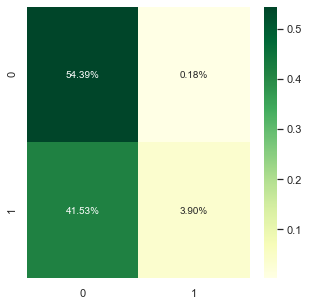

In [55]:
# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(lr_rand_prec_matrix/np.sum(lr_rand_prec_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

As the confusion matrix above makes it clear how poorly this model performs. Even though there is a very small amount of false positives, which is what we want, the model can hardly identify True Negatives at all! It missclassifies non-functional pumps at such a high rate that deployment of resources would go to very few water pumps that need them. This is very bad.

It is clear that focusing on just precision in order to lower false positives is a poor approach for building the model. 

I will now focus on f1_score as my target for iterative modeling.

Below I decided to run a full grid search with the same paramaters as my random grid, only this time with focus on improving f1_score.

In [25]:
start = time.time()

classifier_penalties = ['l1', 'l2']
classifier_Cs = np.logspace(-5, 5, 100)
classifier__solver = ['liblinear']
    
lr_grid = {'penalty' : classifier_penalties,
            'C' : classifier_Cs,
            'solver' : classifier__solver
          }

lr = LogisticRegression()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_grid_f1 = GridSearchCV(estimator=lr,
                          param_grid=lr_grid,
                          scoring='f1',
                          cv=3,
                          n_jobs = -1,
                          verbose=2 
                         )

# RandomizedSearchCV(estimator = lr, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, 
#                                random_state=42, 
#                                n_jobs = -1)
# Fit the random search model
lr_grid_f1.fit(X_train, y_train)


end = time.time()
print(end - start)


# lr_best_grid_f1 = lr_grid_f1.best_estimator_
# lr_best_grid_f1.fit(X_train,y_train)
# y_hat_train_gs = lr_best_grid_f1.predict(X_train)
# y_hat_test_gs = lr_best_grid_f1.predict(X_test)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
469.99079990386963


NameError: name 'lr_best_rand_score' is not defined

In [29]:
 lr_grid_f1.best_estimator_

LogisticRegression(C=5.72236765935022, solver='liblinear')

In [31]:
lr_best_grid_f1 = lr_grid_f1.best_estimator_
lr_best_grid_f1.fit(X_train,y_train)
y_hat_train_gs = lr_best_grid_f1.predict(X_train)
y_hat_test_gs = lr_best_grid_f1.predict(X_test)


print('Training Precision: ', precision_score(y_train, y_hat_train_gs))
print('Testing Precision: ', precision_score(y_test, y_hat_test_gs))
print('\n\n')


print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_gs))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_gs))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train_gs))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test_gs))

Training Precision:  0.7952357133925222
Testing Precision:  0.7879630985503002



Training Accuracy:  0.769095719095719
Testing Accuracy:  0.7663860830527497



Training F1-Score:  0.7259910385570364
Testing F1-Score:  0.72107202680067


[[8276 1448]
 [2715 5381]]


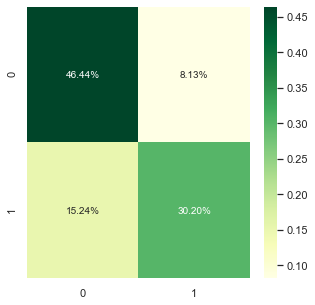

In [54]:
#best grid search confusion matrix
lr_grid_f1_matrix = confusion_matrix(y_test, y_hat_test_gs)
print(lr_grid_f1_matrix)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(lr_grid_f1_matrix/np.sum(lr_grid_f1_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

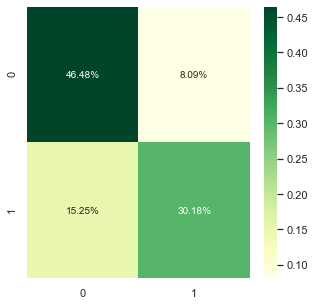

In [52]:
#baseline confusion matrix
fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(lr_base_matrix/np.sum(lr_base_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

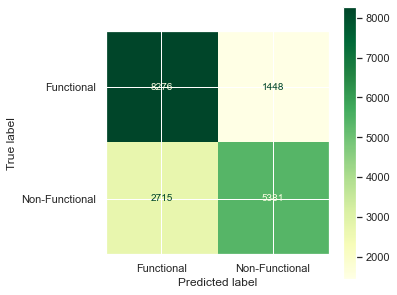

In [53]:
fig, ax = plt.subplots(figsize=(5,5))

plot_confusion_matrix(lr_best_grid_f1,
                      X_test, 
                      y_test, 
                      ax=ax, 
                      cmap='YlGn',
                     display_labels=fig_labels)

plt.show();

The gridsearch did not do much to improve the model. 

### Random Forest Classifier

Below I have created a grid of paramters in order to tune a random forest classifier. This grid will be used to perform a random grid search in order to narrow down the paramters to run a more robust grid search. The run time for a Random Forest has potential to be much higher than a logistic regression model. Therefore, a random search to narrow down the paramters for a grid search was carried out in order to reduce total run time while still keeping a fairly broad search.

In [40]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [41]:
start = time.time()

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(scoring='f1',
                                estimator = rfc, 
                                param_distributions = random_grid, 
                                n_iter = 33, 
                                cv = 3, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)
# Fit the random search model

rfc_random.fit(X_train,y_train)
rfc_best_random = rfc_random.best_estimator_
rfc_best_random.fit(X_train,y_train)
y_hat_train_rrf = rfc_best_random.predict(X_train)
y_hat_test_rrf = rfc_best_random.predict(X_test)


end = time.time()
print(end - start)

print('Training Precision: ', precision_score(y_train, y_hat_train_rrf))
print('Testing Precision: ', precision_score(y_test, y_hat_test_rrf))
print('\n\n')


print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_rrf))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_rrf))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train_rrf))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test_rrf))

Fitting 3 folds for each of 33 candidates, totalling 99 fits
2072.605688095093
Training Precision:  0.9026457450463864
Testing Precision:  0.8049204439096136



Training Accuracy:  0.8801587301587301
Testing Accuracy:  0.8016273849607183



Training F1-Score:  0.863505629057441
Testing F1-Score:  0.7730337078651686


In [37]:
rfc_random.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

[[8265 1459]
 [2076 6020]]


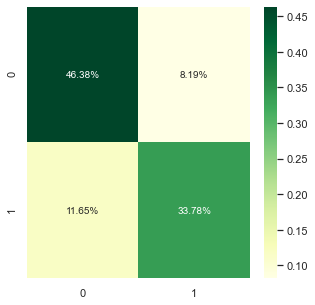

In [51]:
#best random search confusion matrix for Random Forest
lr_grid_f1_matrix_rrf = confusion_matrix(y_test, y_hat_test_rrf)
print(lr_grid_f1_matrix_rrf)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(lr_grid_f1_matrix_rrf/np.sum(lr_grid_f1_matrix_rrf), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

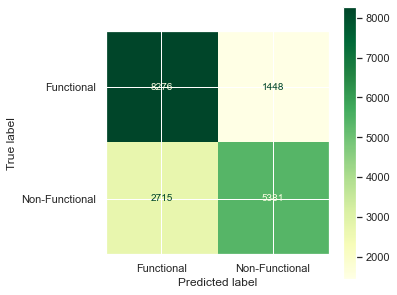

In [50]:
fig, ax = plt.subplots(figsize=(5,5))

plot_confusion_matrix(lr_best_grid_f1,
                      X_test, 
                      y_test, 
                      ax=ax, 
                      cmap='YlGn',
                     display_labels=fig_labels)

plt.show();

This random forest classifier outperforms the best logistic regression model in every relevant metric. It improves upon the model accuracy and precision while also lowering the occurance false negatives. 

A grid search will be performed below to see if any imrpovements can be made to model performance. 

In [44]:
# Number of trees in random forest
n_estimators = [500, 600, 700]
# Number of features to consider at every split
max_features = [14,15,16]
# Maximum number of levels in tree
# Minimum number of samples required to split a node
min_samples_split = [8,10,12]
# Minimum number of samples required at each leaf node
# Create the random grid
cv_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split}

cv_grid

{'n_estimators': [500, 600, 700],
 'max_features': [14, 15, 16],
 'min_samples_split': [8, 10, 12]}

In [45]:
start = time.time()

rfc = RandomForestClassifier()
# Instantiate the grid search model
rfc_gs = GridSearchCV(scoring='f1',
                      estimator = rfc, 
                      param_grid = cv_grid, 
                      cv = 3, 
                      n_jobs = -1, 
                      verbose = 2)


rfc_gs.fit(X_train,y_train)
rfc_best_gs = rfc_gs.best_estimator_
rfc_best_gs.fit(X_train,y_train)
y_hat_train_grf = rfc_best_gs.predict(X_train)
y_hat_test_grf = rfc_best_gs.predict(X_test)


end = time.time()
print(end - start)

print('Training Precision: ', precision_score(y_train, y_hat_train_grf))
print('Testing Precision: ', precision_score(y_test, y_hat_test_grf))
print('\n\n')


print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_grf))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_grf))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train_grf))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test_grf))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
868.361251115799
Training Precision:  0.9079278044322595
Testing Precision:  0.8040468583599574



Training Accuracy:  0.8854978354978355
Testing Accuracy:  0.802020202020202



Training F1-Score:  0.8697507728503817
Testing F1-Score:  0.7739620707329574


[[8252 1472]
 [2056 6040]]


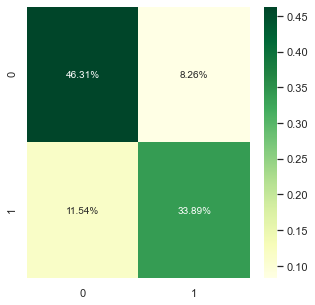

In [48]:
#best grid search confusion matrix for Random Forest
lr_grid_f1_matrix_grf = confusion_matrix(y_test, y_hat_test_grf)
print(lr_grid_f1_matrix_grf)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(lr_grid_f1_matrix_grf/np.sum(lr_grid_f1_matrix_grf), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

#besgt random search matrix
# [[8265 1459]
#  [2076 6020]]

The results of the grid search reduced the number of false positives, which is great, but it slightly increased the number of false negatives. It identified a similar number of functional pumps as the other random forest model, but it also identified slightly more non-functional pumps correctly. The modeling was slightly improved overall. 

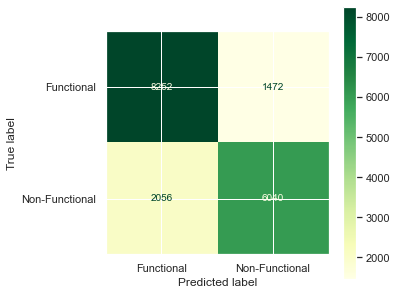

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_confusion_matrix(rfc_best_gs,
                      X_test, 
                      y_test, 
                      ax=ax, 
                      cmap='YlGn',
                     display_labels=fig_labels)

plt.show();

### XGBoost Classification Iterative Modeling


A similar method of iterative modeling was carried out using XGBoost as was used for tuning the random forest classifier: a random grid cv will be used to reduce the number of paramters to perform in a more robust grid search. A baseline XGBoost classifier was first created using default parameters before iterative modeling/hyper-paramter tuning was carried out. 

In [58]:
# Instantiate the model
xgc_base = XGBClassifier()

# Fit the model
xgc_base.fit(X_train, y_train)
y_hat_train = xgc_base.predict(X_train)
y_hat_test = xgc_base.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.8397065362383281
Testing Precision:  0.8348687641230662



Training Recall:  0.5949593069046994
Testing Recall:  0.5932559288537549



Training Accuracy:  0.7624579124579125
Testing Accuracy:  0.7618967452300786



Training F1-Score:  0.696456559820523
Testing F1-Score:  0.6936240883818325


[[8774  950]
 [3293 4803]]


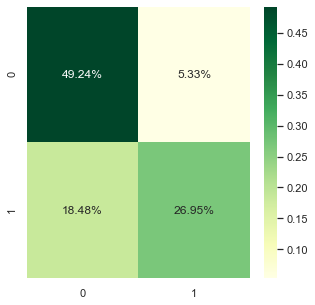

In [61]:
#baseline XGSBoost model
xgs_base_matrix = confusion_matrix(y_test, y_hat_test)
print(xgs_base_matrix)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(xgs_base_matrix/np.sum(xgs_base_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

The baseline XGSBoost model has a low number of false negatives, but a relatively high number of false positives. It also has a lower accuracy than either random forest model. Some hyper-parameter tuning will be carried out below in an attempt to improve the model.

In [62]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgc = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgc_random = RandomizedSearchCV(scoring='f1',
                               estimator = xgc, 
                               param_distributions = params, 
                               n_iter = 33, cv = 3, verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
xgc_random.fit(X_train, y_train)


end = time.time()
print(end - start)


# xgc_best_random = xgc_random.best_estimator_
# xgc_best_random.fit(X_train,y_train)
# y_hat_train_brm = xgc_best_random.predict(X_train)
# y_hat_test_brm = xgc_best_random.predict(X_test)

# print('Training Precision: ', precision_score(y_train, y_hat_train_brm))
# print('Testing Precision: ', precision_score(y_test, y_hat_test_brm))
# print('\n\n')

# print('Training Recall: ', recall_score(y_train, y_hat_train_brm))
# print('Testing Recall: ', recall_score(y_test, y_hat_test_brm))
# print('\n\n')

# print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_brm))
# print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_brm))
# print('\n\n')

# print('Training F1-Score: ', f1_score(y_train, y_hat_train_brm))
# print('Testing F1-Score: ', f1_score(y_test, y_hat_test_brm))

Fitting 3 folds for each of 33 candidates, totalling 99 fits
3434.718137025833


NameError: name 'lr_best_rand_score' is not defined

In [63]:
xgc_best_random = xgc_random.best_estimator_
xgc_best_random.fit(X_train,y_train)
y_hat_train_brm = xgc_best_random.predict(X_train)
y_hat_test_brm = xgc_best_random.predict(X_test)

print('Training Precision: ', precision_score(y_train, y_hat_train_brm))
print('Testing Precision: ', precision_score(y_test, y_hat_test_brm))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train_brm))
print('Testing Recall: ', recall_score(y_test, y_hat_test_brm))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_brm))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_brm))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train_brm))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test_brm))

Training Precision:  0.8566377816291161
Testing Precision:  0.8387410772225827



Training Recall:  0.6488317143607246
Testing Recall:  0.6385869565217391



Training Accuracy:  0.7894179894179895
Testing Accuracy:  0.7800224466891134



Training F1-Score:  0.7383925903794443
Testing F1-Score:  0.7251051893408134


[[8730  994]
 [2926 5170]]


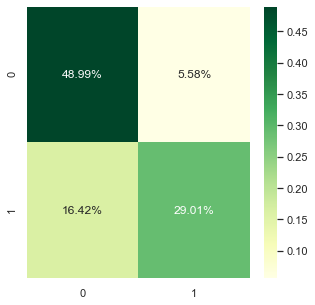

In [65]:
#baseline XGSBoost model
xgs_rand_matrix = confusion_matrix(y_test, y_hat_test_brm)
print(xgs_rand_matrix)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(xgs_rand_matrix/np.sum(xgs_rand_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

Improvements to accuracy and f1-score. Still needs improvement to both to compete with the random forest models.

In [64]:
xgc_best_random

XGBClassifier(colsample_bytree=0.8, gamma=0.5, max_depth=5, subsample=1.0)

In [66]:
params2 = {
        'gamma': [0.1, 0.3, 0.5],
        'colsample_bytree': [0.8, 0.9],
        'max_depth': [4, 5, 6]
        }

start = time.time()

xgc2 = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgc_gs = GridSearchCV(scoring='f1',
                      estimator = xgc2, 
                      param_grid = params2, 
                      cv = 3, 
                      verbose=2,  
                      n_jobs = -1)


xgc_gs.fit(X_train, y_train)
xgc_best_gs = xgc_gs.best_estimator_
xgc_best_gs.fit(X_train,y_train)
y_hat_train_bgs = xgc_best_gs.predict(X_train)
y_hat_test_bgs = xgc_best_gs.predict(X_test)


end = time.time()
print(end - start)

print('Training Precision: ', precision_score(y_train, y_hat_train_bgs))
print('Testing Precision: ', precision_score(y_test, y_hat_test_bgs))
print('\n\n')


print('Training Accuracy: ', accuracy_score(y_train, y_hat_train_bgs))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test_bgs))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train_bgs))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test_bgs))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
553.8524680137634
Training Precision:  0.864413680781759
Testing Precision:  0.8411867364746946



Training Accuracy:  0.8002645502645502
Testing Accuracy:  0.7870370370370371



Training F1-Score:  0.7541517421035494
Testing F1-Score:  0.7364400305576775


[[8730  994]
 [2926 5170]]


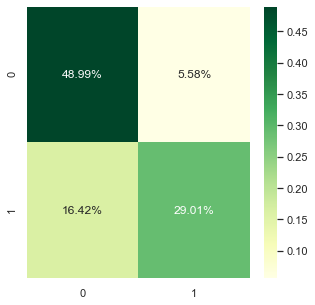

In [67]:
#baseline XGSBoost model
xgs_rand_matrix = confusion_matrix(y_test, y_hat_test_brm)
print(xgs_rand_matrix)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(xgs_rand_matrix/np.sum(xgs_rand_matrix), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

[[8252 1472]
 [2056 6040]]


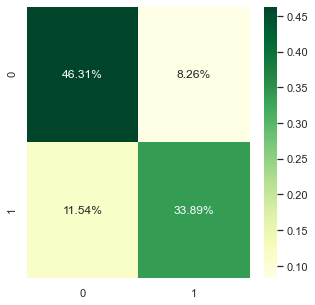

In [68]:
#best grid search confusion matrix for Random Forest
lr_grid_f1_matrix_grf = confusion_matrix(y_test, y_hat_test_grf)
print(lr_grid_f1_matrix_grf)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(lr_grid_f1_matrix_grf/np.sum(lr_grid_f1_matrix_grf), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

#besgt random search matrix
# [[8265 1459]
#  [2076 6020]]

The grid search produced a pretty good model, but my random forest classifier still performed better. 

## Evaluation

My random forest models outperformed my best logistic regression and XGSBoost models in regards to the metrics that are most important given the buisness problem at hand.

The best random forest model has the lowest false positive rate, a low false negative rate, and the highest accuracy. 

About 11.5% of pumps would be missclassified as functional using my best model. This means that 11.5% of the pumps would go untreated if it was deployed to conduct predicitve maintenance. However, it correctly identifies a high number of functional pumps correctly, which would save a lot of valuable resources, time and money, and it also identifies a large number of non-functional correctly. Only about 8.25% of functional pumps would be incorrectly identified as non-functional. This is the resource/time/money sink of my model. 

## Conclusions

I believe that my best classification model provides a powerful enough predictive ability to prove very valuable to the Ministry of Water. The amount of resources saved, the relatively low number of missclassified functional pumps, and the elimination of the need to physically sweep the functionality of all pumps can bring access to potable drinking water to a larger number of communities than before without predictive maintenance. 

In [76]:
df_binary['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

[[8252 1472]
 [2056 6040]]


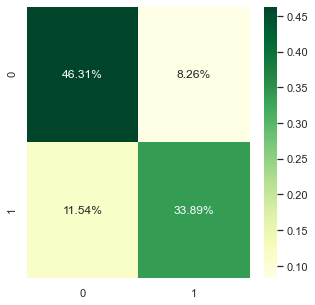

In [72]:
#best grid search confusion matrix for Random Forest
print(lr_grid_f1_matrix_grf)

# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))


sns.heatmap(lr_grid_f1_matrix_grf/np.sum(lr_grid_f1_matrix_grf), annot=True, 
            fmt='.2%', cmap='YlGn', ax=ax)

plt.show();

Thank you! For questions or comments please feel free to reach me by email.

Author: Dylan Dey

Email: ddey2985@gmail.com